# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

Dataset here : https://www.batadal.net/data.html You will need Training Dataset 1, Training Dataset 1 and Test Dataset.

## Group Number : 15

## Student 1 
### Name : Nikhil Saldanha
### ID : 4998707

## Student 2
### Name : Sharwin Bobde
### ID : 5011639

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

### Instructions for setting up
- Create a folder for the data called `data/`.
- Download the data into `data/` from [here](https://www.batadal.net/data.html).
- Setup virtualenv: `virtualenv -p python3 env`
- Enter virtualenv: `source env/bin/activate`
- Start Jupyter Server: `jupyter notebook .`

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
from tqdm import tqdm

In [6]:
from sklearn.neighbors import LocalOutlierFactor

In [7]:
from sklearn.metrics import confusion_matrix

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [8]:
data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
# account for space after the comma in the delimiter
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

# convert DATETIME column to datetime
data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

<ipython-input-8-356782e260f6>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")


In [9]:
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

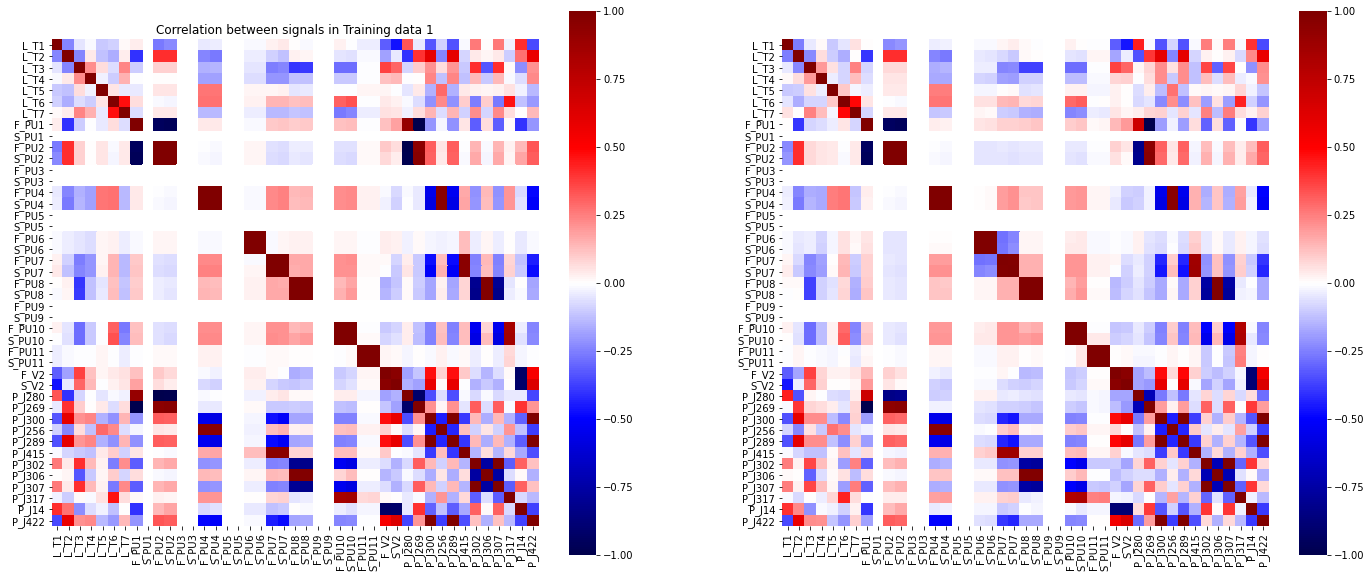

In [10]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(24, 10))

sns.heatmap(data_1[signals].corr(), square=True, vmin=-1, vmax=1, ax=ax1, cmap='seismic')
ax1.set_title("Correlation between signals in Training data 1")
sns.heatmap(data_2[signals].corr(), square=True, vmin=-1, vmax=1, ax=ax2, cmap='seismic')
ax1.set_title("Correlation between signals in Training data 1")
plt.show()

100%|██████████| 43/43 [00:00<00:00, 1104.43it/s]


Rendering... Please wait


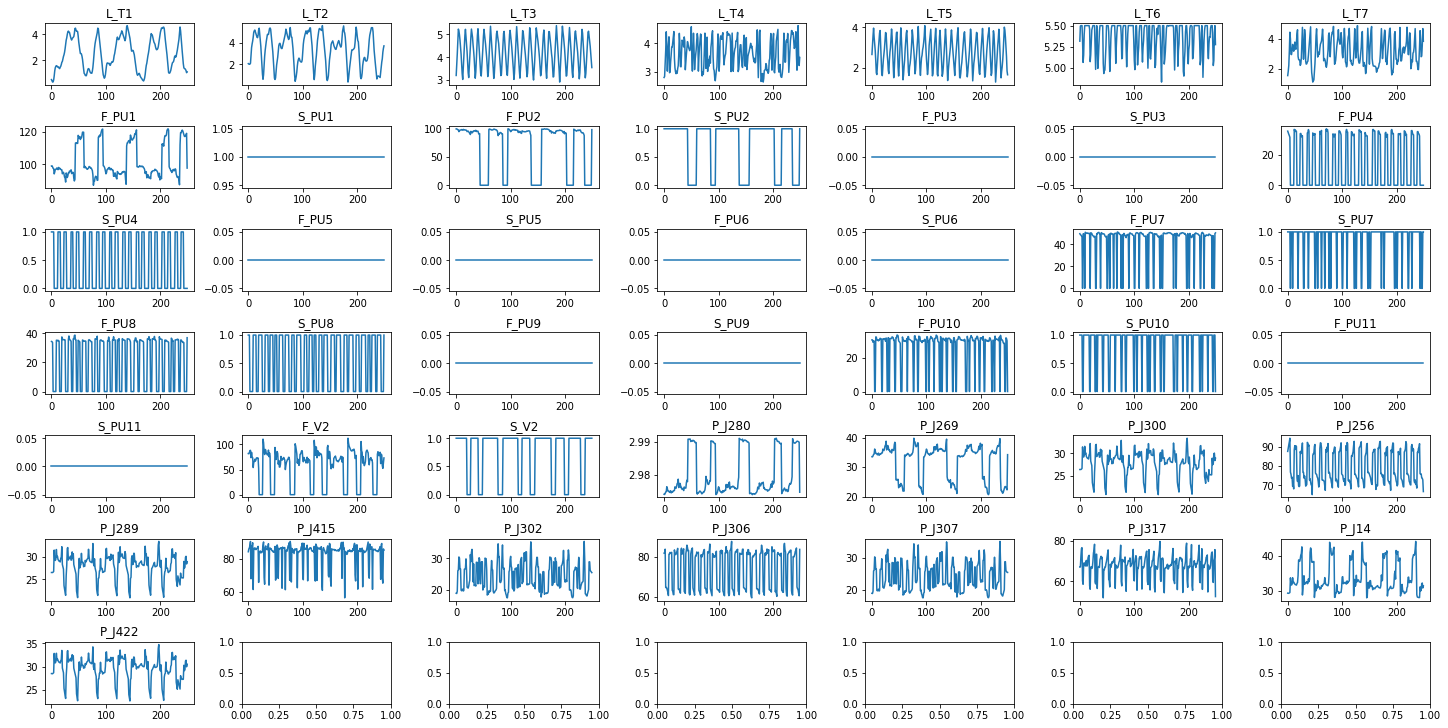

In [11]:
fig, axs = plt.subplots(7,7, constrained_layout=True)
fig.set_size_inches((20,10))
for i in tqdm(range(len(signals))):
       a,b = (int(i/7), i%7)
       axs[a,b].plot(range(250), data_1[signals[i]][0:250])
       axs[a,b].set_title(signals[i])
print('Rendering... Please wait')
plt.show()

100%|██████████| 43/43 [00:00<00:00, 484.55it/s]


Rendering... Please wait


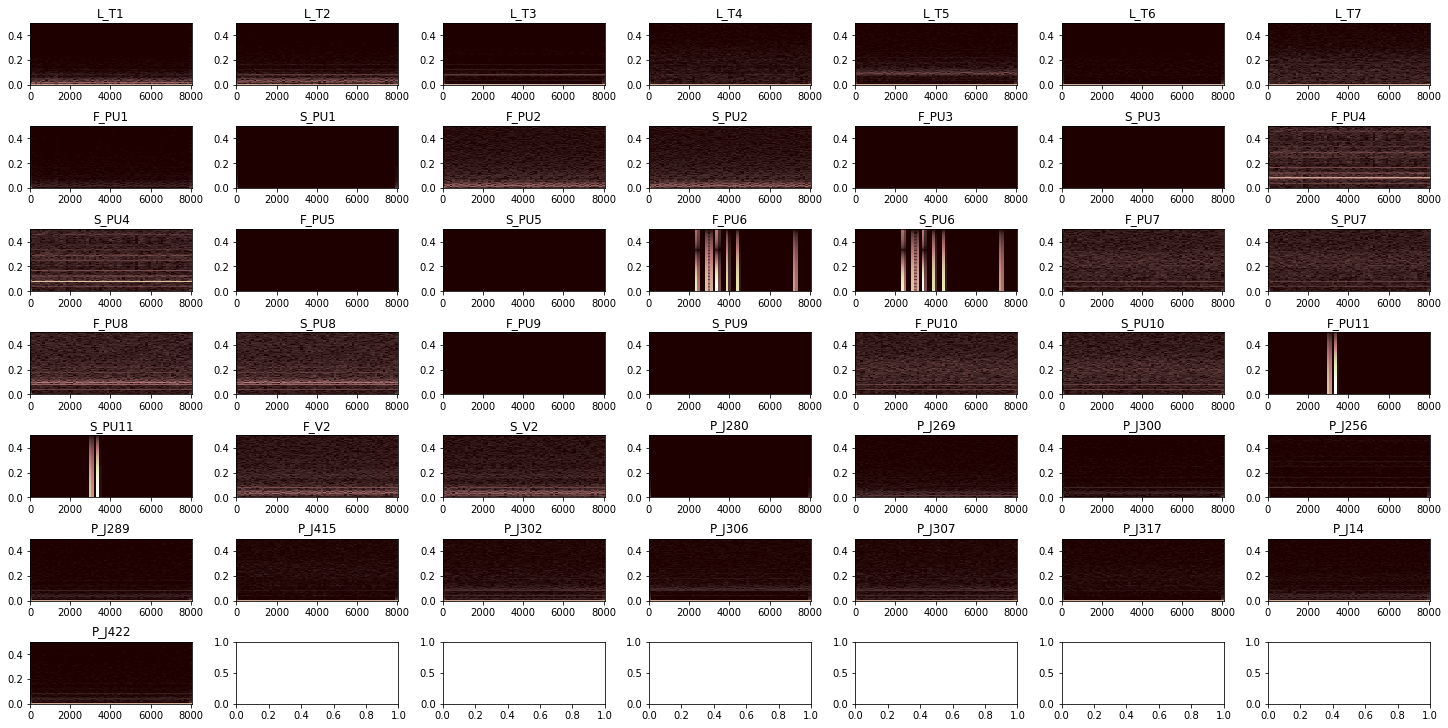

In [12]:
fig, axs = plt.subplots(7,7, constrained_layout=True)
fig.set_size_inches((20,10))
for i in tqdm(range(len(signals))):
       a,b = (int(i/7), i%7)
       f, t, Zxx = stft(data_1[signals[i]][0:8000], nperseg=256)
       axs[a,b].pcolormesh(t, f, np.abs(Zxx), cmap='pink')
       axs[a,b].set_title(signals[i])
print('Rendering... Please wait')
plt.show()

In [13]:
def slide_dataset(data: np.array, window_size: int, stride: int = 1) -> np.array:
    """
    Takes Nx1 dimensional data in form of a numpy array and
    creates data by sampling in a window_size W and stride S.
    Returns a (N - W)/S x W dimensional data
    """
    N = data.shape[0]
    num_samples = int(N - window_size / stride)
    
    # new empty numpy array to store the data with sliding window
    slid_dataset = np.empty((num_samples, window_size))

    # loop over the data and sample according
    # to window size and stride
    for i in range(window_size, N, stride):
        slid_dataset[i-window_size] = data[i-window_size:i]
    
    return slid_dataset

In [14]:
def plot_prediction(y_true, y_pred, ax, title, num_points=1000):
    ax.plot([i for i in range(num_points)], y_true[:num_points], label="actual")
    ax.plot([i for i in range(num_points)], y_pred[:num_points], label="predicted")
    ax.legend()
    ax.set_title(title)

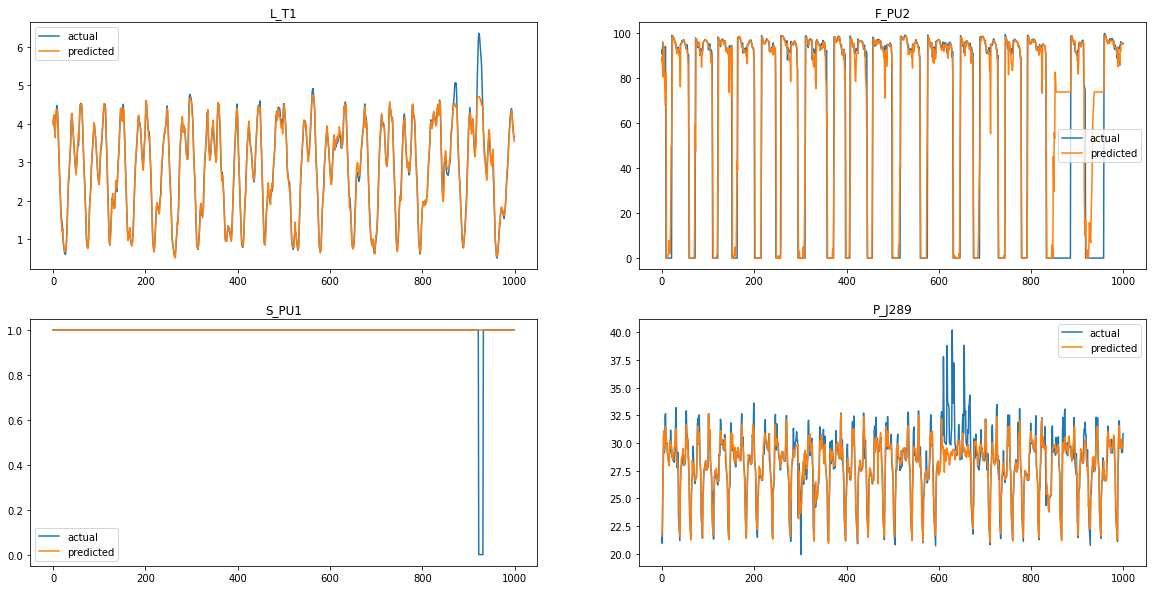

In [15]:
# decide window size
window_size = 24

# decide signals
signals = ["L_T1", "F_PU2", "S_PU1", "P_J289"]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches((20,10))
for i, signal in enumerate(signals):
    # create sliding window dataset
    slid_train = slide_dataset(data_1[signal].to_numpy(), window_size)
    slid_test = slide_dataset(test_data[signal].to_numpy(), window_size)

    # create train, test and validation sets
    X_train = slid_train[:,:window_size-1]
    y_train = slid_train[:,window_size-1]

    X_test = slid_test[:,:window_size-1]
    y_test = slid_test[:,window_size-1]
    
    # create a random forest regression model
    rf_clf = RandomForestRegressor()
    
    # fit and predict
    rf_clf.fit(X_train, y_train)
    
    y_pred_test = rf_clf.predict(X_test)
    plot_prediction(y_test, y_pred_test, axs[int(i/2), i%2], title=signal)
plt.show()

### 1b. Answers to the three questions

**1. What types of signals are there?**

In the dataset, the signals prefixed with "S" are state variables which are discrete, the signals prefixed with "L" denote the water levels, "F" signals are for flow and "P" signals are for inlet and outlet pressure. We see that each of these signals have their own characteristic shape.

**2. Are the signals correlated? Do they show cyclic behavior?**

TODO: sharwin

**3. Is predicting the next value in a series easy or hard? Use any method from class**

We make an attempt at predicting the next value in the series of the signals L_T1, F_PU2, S_PU1, P_J289 using the sliding window technique. According to our observations, the model can reasonable predict the next value of the signal when there are no sudden and large changes in it. In our visualizations above, we can see that when S_PU1 drops to 0 and then back to 1 in a short interval, the model is not able to predict this. We can see similar patterns in other signals as well. Hence, we would say that whether it is hard or easy depends on the characteristic of the signal itself.

## 2. LOF task – 1/2 A4 – Nikhil Saldanha

### 2a. Plot LOF scores

In [16]:
# remove label and datetime column
X_train = data_1[set(data_1.columns)-{"ATT_FLAG", "DATETIME"}].to_numpy()
y_train = np.zeros((X_train.shape[0], ))

X_valid = data_2[set(data_2.columns)-{"ATT_FLAG", "DATETIME"}].to_numpy()
y_valid = data_2["ATT_FLAG"].to_numpy()
# convert to 1s for attack and 0s for normal
y_valid = y_valid == 1

lofs = []
nns = [i for i in range(1, 120)]
tps = []
fns = []
for nn in tqdm(nns):
    clf = LocalOutlierFactor(n_neighbors=nn, algorithm='kd_tree', leaf_size=100,
                             metric='minkowski', p=1, contamination="auto", novelty=True, n_jobs=-1)
    clf.fit(X_train)
    lof = clf.negative_outlier_factor_
    lofs.append(lof)

    y_pred = clf.predict(X_valid)
    y_pred = y_pred == -1
    y_pred = y_pred.astype(float)

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    tps.append(tp)
    fns.append(fn)

100%|██████████| 119/119 [01:46<00:00,  1.12it/s]


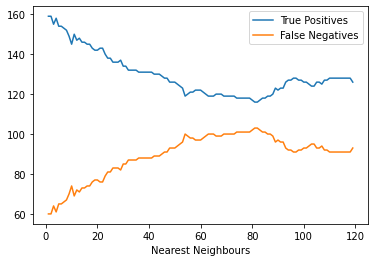

In [17]:
plot_df = pd.DataFrame({"True Positives": tps, "False Negatives": fns, "Nearest Neighbours": nns})
sns.lineplot(x="Nearest Neighbours", y=tps, data=plot_df, legend='brief', label="True Positives")
sns.lineplot(x="Nearest Neighbours", y=fns, data=plot_df, legend='brief', label="False Negatives")

We choose a nearest neighbour value of 95 since at that value, the number of TPs and FNs are stable and do not change with increase nearest neighbour values. At this value, we see the distribution of LOF scores below:

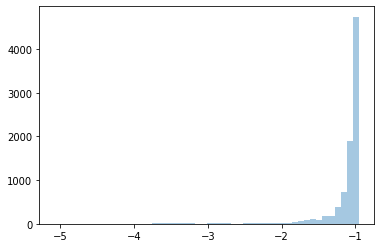

In [18]:
sns.distplot(lofs[94], kde=False)
plt.show()

### 2b. Analysis and answers to the questions

**1. Do you see large abnormalities in the training data? Can you explain why these occur?**
Yes, we can see the large abnormalities in the training data through the LOF scores above. The model takes -1.5 as the threshold below which the samples are classified as outliers. These are possibly the datapoints that have sudden changes in their values as we saw in the familiarization task.


**2. It is best to remove such abnormalities from the training data since you only want to model normal behavior?**
We would say that it is not a good idea to remove these from the training data since they are already part of normal behaviour and we should model these kinds of patterns as well.


**3. Describe the kind of anomalies you can detect using LOF**

With LOF you can detect point anomalies since it measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. A point anomaly is defined as: A single instance of data that is anomalous since it deviates largely from the rest of the data points.

## 3. PCA task – 1/2 A4 – Sharwin Bobde

### 3a. Plot PCA residuals

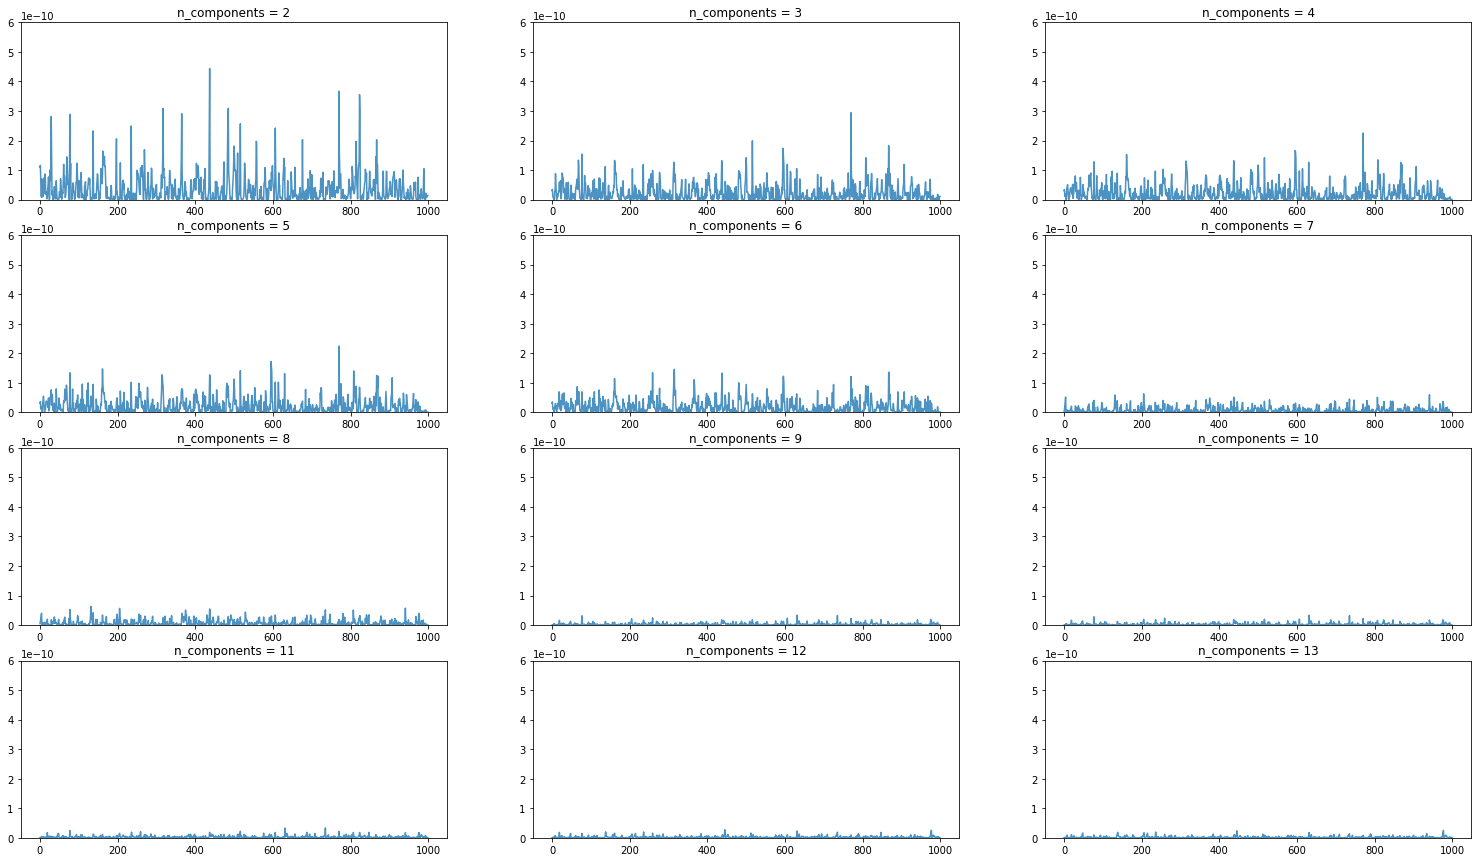

In [19]:
from PCA import PCA_Component
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
X = data_1[signals].to_numpy()

signal_to_PLOT = signals.index('P_J280') # selected P_J280 because shows importance
pca = PCA_Component()
pca.set_X(X)

f, axs = plt.subplots(4,3,figsize =(26, 15))
for i in range(12):
    n_components = i+2 # start with 2 components
    pca.PCA_fit_transform(n_components)
    R = pca.calculate_residual(X)
    s = R[:,signal_to_PLOT]

    axs[int(i/3), i%3].set_title("n_components = " + str(n_components))
    axs[int(i/3), i%3].plot(range(1000), s[0:1000], alpha = 0.8)
    axs[int(i/3), i%3].set_ylim((0,6e-10)) # consistent y-axis

### 3b. Analysis and answers to the questions

### Choosing `n_components`
We will use the mean and standard deviation of anomaly score (the probability of a row being an anomaly) to choose. The anomaly score should be low for normal data and high for data we know is outlier. Moreover, we can split `data 2` in two parts (inlier and outlier) to see that it firs the inliers as normal data.

100%|██████████| 41/41 [00:08<00:00,  4.82it/s]


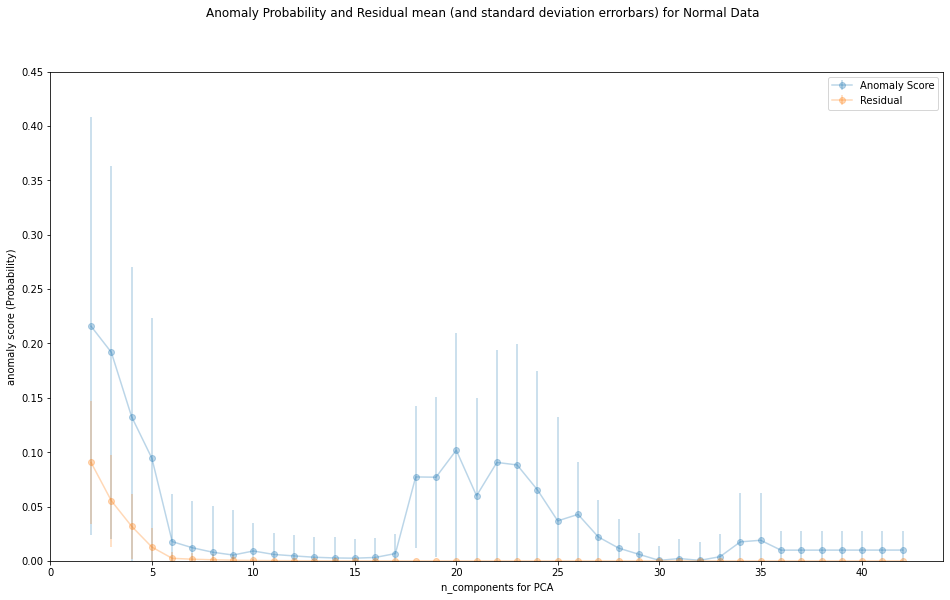

In [20]:
pca = PCA_Component()
pca.set_X(X)

per_n_components = []
per_n_components_R = []

for n_components in tqdm(range(2, 43)): # try all possible n_components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(X)
    per_n_components.append(score)

    R = pca.calculate_residual(X)
    R = np.sum(R, axis=1) # sum up residuals for all signals
    per_n_components_R.append(R)
    
mean_ = np.mean(per_n_components, axis=1)
std_ = np.std(per_n_components, axis=1)
mean_R = np.mean(per_n_components_R, axis=1)
std_R= np.std(per_n_components_R, axis=1)

fig = plt.figure(figsize=(16, 9))
fig.suptitle("Anomaly Probability and Residual mean (and standard deviation errorbars) for Normal Data")
plt.errorbar(x=range(2, 43), y=mean_, yerr=std_, fmt='o-', alpha = 0.3, label="Anomaly Score")
plt.errorbar(x=range(2, 43), y=mean_R, yerr=std_R, fmt='o-', alpha = 0.3, label="Residual")
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.ylim((0,0.45)) # consistent y-axis
plt.legend()
plt.show()

100%|██████████| 41/41 [00:06<00:00,  6.79it/s]


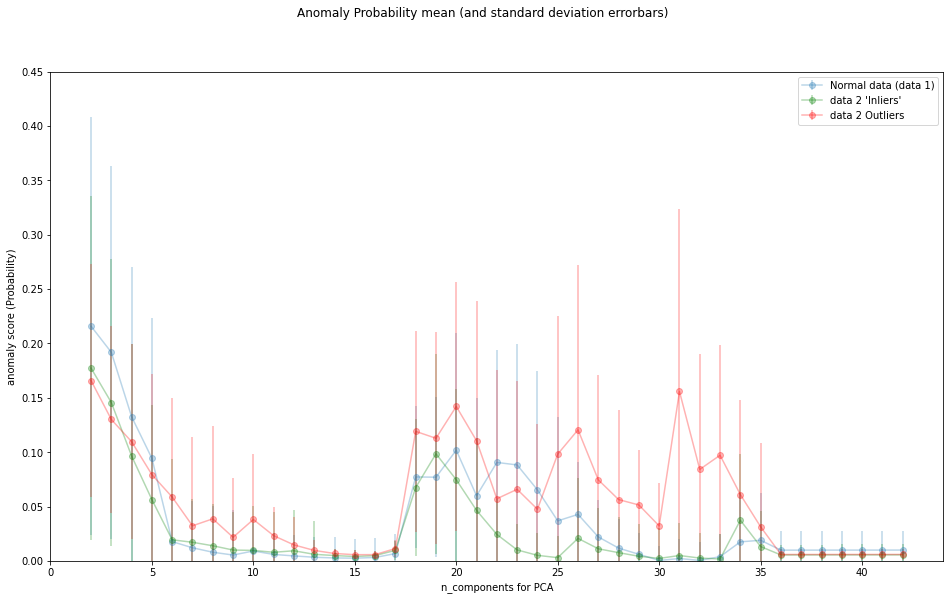

In [21]:
pca = PCA_Component()
pca.set_X(X) # fit for normal data
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]
Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]

per_n_components_outlier = []
per_n_components_inlier = []
for n_components in tqdm(range(2, 43)): # try all possible n_components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(Z_outliers)
    per_n_components_outlier.append(score)
    score = pca.anomaly_score(Z_inliers)
    per_n_components_inlier.append(score)
    
mean_outlier = np.mean(per_n_components_outlier, axis=1)
std_outlier = np.std(per_n_components_outlier, axis=1)
mean_inlier = np.mean(per_n_components_inlier, axis=1)
std_inlier = np.std(per_n_components_inlier, axis=1)


fig = plt.figure(figsize=(16, 9))
fig.suptitle("Anomaly Probability mean (and standard deviation errorbars)")
plt.errorbar(x=range(2, 43), y=mean_, yerr=std_, fmt='o-', alpha=0.3, label="Normal data (data 1)")
plt.errorbar(x=range(2, 43), y=mean_inlier, yerr=std_inlier, fmt='o-', alpha=0.3, c='g', label="data 2 'Inliers'")
plt.errorbar(x=range(2, 43), y=mean_outlier, yerr=std_outlier, fmt='o-', alpha=0.3,c='r', label="data 2 Outliers")
plt.ylim((0,0.45)) # consistent y-axis
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.legend()
plt.show()

### Select `n_components = 10`
This is because it models the normal data (entire data_1 and data_2 inliers) well with very low residual error AND it shows high anomaly score for data we know is outlier while generalising using less number of components.

### Abnormalities in training data

**Q. Do you see large abnormalities in the trainingdata?**

In the above plot it is quite visible that outlier data has higher probability of being tagged anomalous. We see at `n_components = 31` this observation is most prominant.

**Q. Can you explain why these occur?**

This is because the outlier points (attacks) have abnormal behaviour and their inverse PCA mapping is very erroneous and thus have higher residual. This is because these points have high variance for principal components which usually shouldn't.

**Q. Describe the kind of anomalies you can detect using PCA.**

We can detect outlier points which have a different variance than the regular distribution in the direction of the principal components.

## 4. ARMA task – 1/2 A4 - Nikhil Saldanha

### 4a. Print relevant plots and/or metrics to determine the parameters.

### 4b. Plots to study the detected anomalies

### 4c. Analysis and answers to the questions

## 5. N-gram task – 1/2 A4 - Sharwin Bobde

### 5a. Visualise discretization

In [22]:
from N_gram import N_gram_Component
import datetime

# Selecting a subset of signals
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'F_PU2', 'S_PU2', 'F_PU4', 'S_PU4',
       'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
       # make test data
test_data['ATT_FLAG'] = pd.Series(np.zeros(test_data.shape[0])) # default 0 (no-attack)

# start setting values
attack_times = [
    [pd.Timestamp("2017-01-16T09"), pd.Timestamp("2017-01-19T06")],
    [pd.Timestamp("2017-01-30T08"), pd.Timestamp("2017-02-02T00")],
    [pd.Timestamp("2017-02-09T03"), pd.Timestamp("2017-02-10T09")],
    [pd.Timestamp("2017-02-12T01"), pd.Timestamp("2017-02-13T07")],
    [pd.Timestamp("2017-02-24T05"), pd.Timestamp("2017-02-28T08")],
    [pd.Timestamp("2017-03-10T14"), pd.Timestamp("2017-03-13T21")],
    [pd.Timestamp("2017-03-25T20"), pd.Timestamp("2017-03-27T01")]
]

for times in attack_times:
    indexes = np.where(test_data['DATETIME'].between(times[0], times[1], inclusive=True))[0]
    test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)

X = data_1[signals].to_numpy()

<ipython-input-22-4adbb2b2046c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)


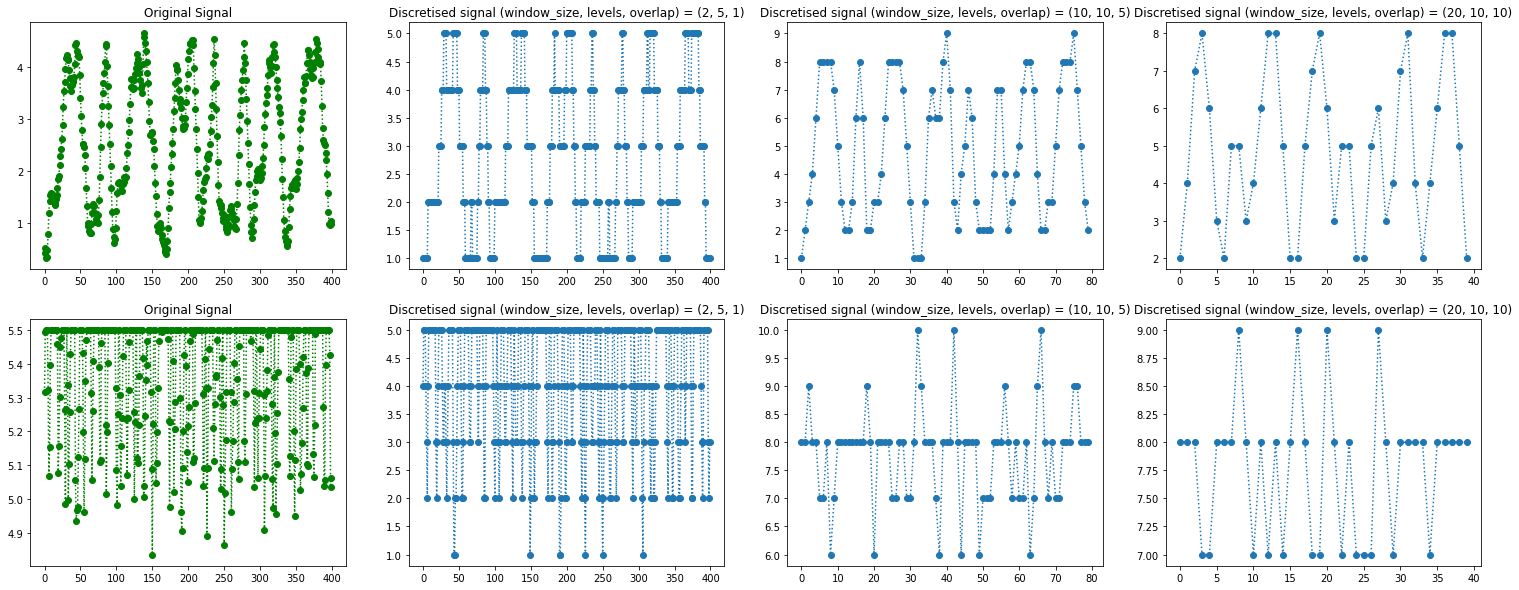

In [23]:
N_gram = N_gram_Component(2, len(signals))

# Plot
# different window_size and overlap
params = np.array([[2, 5, 1], [10, 10, 5], [20, 10, 10]])
fig, axs = plt.subplots(2,4)
fig.set_size_inches((26,10))
x_range = 400
axs[0,0].set_title('Original Signal')
axs[0,0].plot(range(x_range), X[0:x_range, 0], 'o:g')
axs[1,0].set_title('Original Signal')
axs[1,0].plot(range(x_range), X[0:x_range, 5], 'o:g')

for i in range(np.shape(params)[0]):
    X_windowed = N_gram.discretise(X, window_size=params[i,0], levels =params[i,1],  overlap=params[i,2])
    x_range_ = x_range / (params[i,0] - params[i,2])
    axs[0,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[0,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 0], 'o:')
    axs[1,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[1,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 5], 'o:')

plt.show()

Lets select discretization parameters (window_size, levels, overlap) as (2, 5, 1)

### 5b. Analysis and answers to the questions. Also provide relevant plots.

### Selct $L$ and $N$ now

In [24]:
# Z is dataset_2
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]

Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]
Z_outlier_labels = Z_labels[Z_outlier_indexes]
Z_inlier_labels = np.zeros(len(Z_inlier_indexes))

# discretization is done only once 
params = (2,5,1)
Z_inlier_windowed = N_gram.discretise(Z_inliers, window_size=params[0], levels=params[1],  overlap=params[2])
Z_outlier_windowed = N_gram.discretise(Z_outliers, window_size=params[0], levels=params[1],  overlap=params[2])

Z_inlier_labels = N_gram.discretise_labels(Z_inlier_labels, window_size=params[0], overlap=params[2])
Z_outlier_labels = N_gram.discretise_labels(Z_outlier_labels, window_size=params[0], overlap=params[2])

# prepare test data
test_X = test_data[signals].to_numpy()
test_X_windowed = N_gram.discretise(test_X, window_size=params[0], levels=params[1],  overlap=params[2])
test_Y = test_data['ATT_FLAG'].to_numpy()
test_Y_windowed = N_gram.discretise_labels(test_Y, window_size=params[0], overlap=params[2])
print(test_X.shape)
print(test_Y.shape)

(2089, 36)
(2089,)


In [26]:
from metrics import run_metrics
acc = []
auc = []
L_arr = [10, 20, 30] # above 20 it we highly undersample anomaly class
for L in L_arr:
    acc_ = []
    auc_ = []
    for N in range(1,5): # only upto 4 due to high processing time
        N_gram = N_gram_Component(N, len(signals))
        Z_in_profiles = N_gram.generate_profiles(Z_inlier_windowed, L)
        Z_in_profile_labels = N_gram.generate_profile_labels(Z_inlier_labels, L)

        Z_out_profiles = N_gram.generate_profiles(Z_outlier_windowed, L)
        Z_out_profile_labels = N_gram.generate_profile_labels(Z_outlier_labels, L)

        # Stack train data together for training k-NearestNeighbour
        train_X = np.vstack((Z_in_profiles, Z_out_profiles))
        train_Y = np.vstack((Z_in_profile_labels, Z_out_profile_labels))


        test_X_profiles = N_gram.generate_profiles(test_X_windowed, L)
        test_X_profile_labels = N_gram.generate_profile_labels(test_Y_windowed, L)

        N_gram.fit_kNN(train_X, train_Y)
        y_pred = N_gram.classify(test_X_profiles, L)

        result = run_metrics(test_X_profile_labels, y_pred)
        acc_.append(result['accuracy']) 
        auc_.append(result['auc']) 
        print(str([L,N]) + " done")
    acc.append(acc_)
    auc.append(auc_)
print("Completed :)")

/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)
/home/sharwinbobde/envs/CyberDA/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[10, 1] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[10, 2] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[10, 3] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[10, 4] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)
/home/sharwinbobde/envs/CyberDA/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[20, 1] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[20, 2] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[20, 3] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[20, 4] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)
/home/sharwinbobde/envs/CyberDA/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[30, 1] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[30, 2] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[30, 3] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[30, 4] done
Completed :)


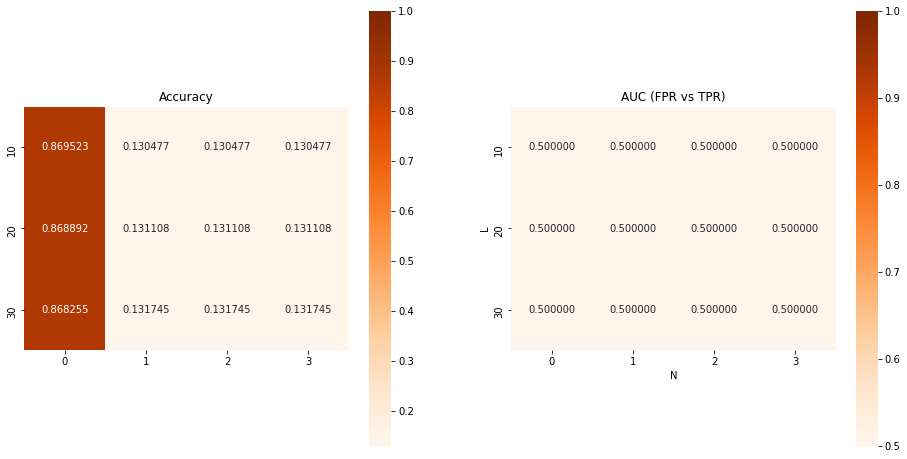

In [27]:
import seaborn as sns
fig, axs = plt.subplots(1, 2,figsize=(16,8))
axs[0].set_title("Accuracy")
sns.heatmap(acc, square=True, annot=True, fmt=".6f", cmap='Oranges', vmax=1, xticklabels=range(0,4), ax=axs[0], yticklabels=L_arr)
axs[1].set_title("AUC (FPR vs TPR)")
sns.heatmap(auc, square=True, annot=True, fmt=".6f", cmap='Oranges', vmax=1, xticklabels=range(0,4), ax=axs[1], yticklabels=L_arr)
plt.xlabel('N')
plt.ylabel('L')
plt.show()

### Explaination
After discretization I tried combinations of L and N. For every block L I calculated N-Gram grequencies and made a profile signature. I found matching labels for this too. I used dataset 2 to charactersise normal and anomalous signatures. Using dataset1 causes heavy oversampling of the normal class.

Clearly there are a lot of things to optimise:
window_size, discretization levels, overlap, L, N, k in k-NN, minory class sampling... thus it proved to be quite difficult to optimise. Looking at the AUC the k-NN is clearly biased and always classifies as either always all 1s or all 0s

## 6.Comparision task 1 A4

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.